# EDA ds003029 (Epilepsy-iEEG-Multicenter-Dataset)

> This notebook is built for 3 functions:
> 1) **Participant metadata** (EDA + plots)
> 2) **Tổng quan signal** (EDA with sidecar/metadata + plots)
> 3) **Visualize 1 case signal** (load BrainVision + waveform/PSD)

> Before running part 3, please do the get data tutorial in: **`get_data_tutorial_ds003029.md`**.

Dataset root mặc định: `EEG/ds003029`

## How to run
- Run the cell sequentially
- Only needs metadata/plots: run all cells before **Phần 2**.
- Needs to visualize signal: request `git annex get`, file `.eeg/.vhdr/.vmrk` at least 1 run (check `.md`).

In [3]:
from __future__ import annotations

import json
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATASET_ROOT = Path('EEG') / 'ds003029'
assert DATASET_ROOT.exists(), f'Không thấy dataset tại: {DATASET_ROOT.resolve()}'

print('Dataset root:', DATASET_ROOT.resolve())
print('Top-level files:', [p.name for p in sorted(DATASET_ROOT.iterdir()) if p.is_file()][:20])
print('Top-level dirs:', [p.name for p in sorted(DATASET_ROOT.iterdir()) if p.is_dir()][:20])

Dataset root: C:\Users\LENOVO\Downloads\eeg\EEG\ds003029
Top-level files: ['.bidsignore', '.gitattributes', 'CHANGES', 'dataset_description.json', 'participants.json', 'participants.tsv', 'README']
Top-level dirs: ['.datalad', '.git', 'sourcedata', 'sub-jh101', 'sub-jh102', 'sub-jh103', 'sub-jh104', 'sub-jh105', 'sub-jh106', 'sub-jh108', 'sub-pt01', 'sub-pt10', 'sub-pt11', 'sub-pt12', 'sub-pt13', 'sub-pt14', 'sub-pt15', 'sub-pt16', 'sub-pt17', 'sub-pt2']


## Phần 1 — Participant metadata (EDA + plots)

Mục tiêu:
- Hiểu phân bố participant theo các biến nhân khẩu học/clinic có trong `participants.tsv`
- Trực quan hóa missingness và các biến quan trọng (tùy theo dataset có cột nào)

participants shape: (35, 11)


,participant_id,age,sex,hand,outcome,engel_score,ilae_score,date_follow_up,ethnicity,years_follow_up,site
0,sub-jh101,NaN,NaN,NaN,F,4.0,6.0,NaN,NaN,1.0,JHH
1,sub-jh102,NaN,NaN,NaN,NR,-1.0,-1.0,NaN,NaN,1.0,JHH
2,sub-jh103,NaN,NaN,NaN,F,4.0,6.0,NaN,NaN,1.0,JHH
3,sub-jh104,NaN,NaN,NaN,NR,-1.0,-1.0,NaN,NaN,1.0,JHH
4,sub-jh105,NaN,NaN,NaN,S,1.0,1.0,NaN,NaN,1.0,JHH


columns: ['participant_id', 'age', 'sex', 'hand', 'outcome', 'engel_score', 'ilae_score', 'date_follow_up', 'ethnicity', 'years_follow_up', 'site']


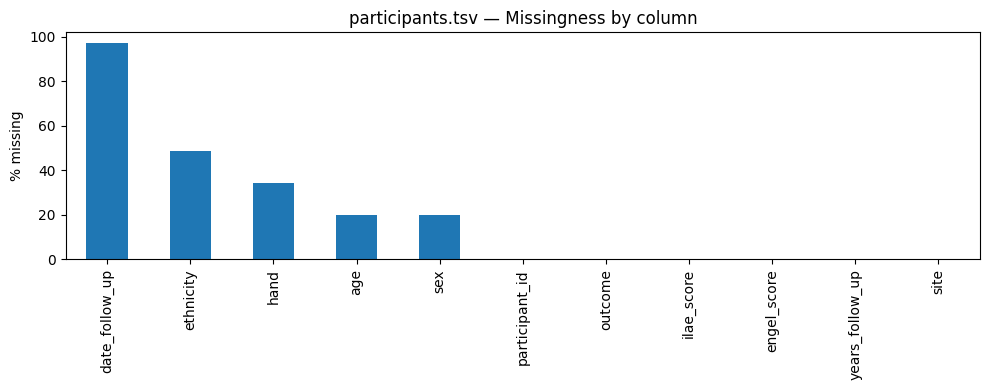

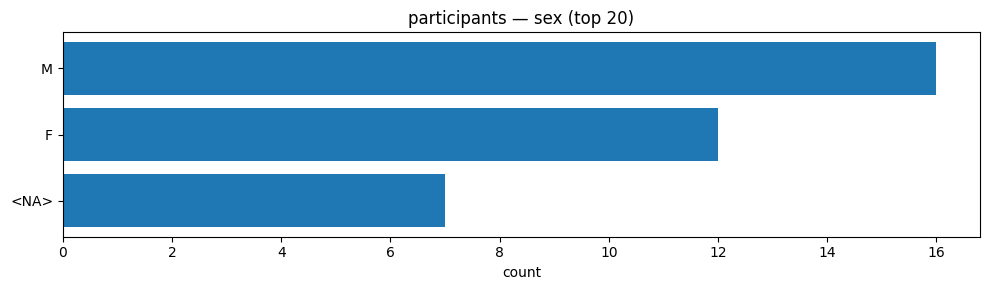

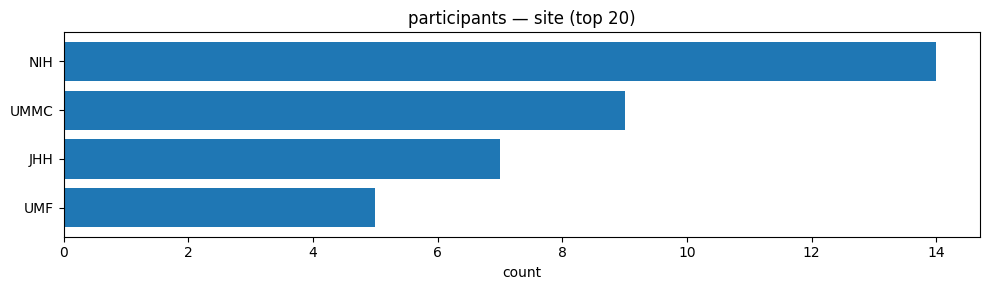

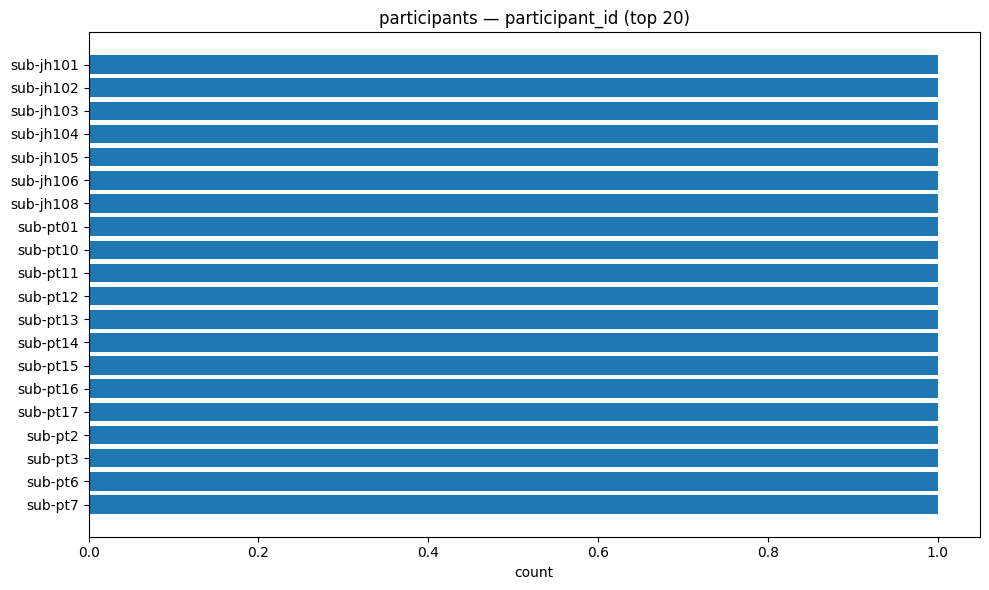

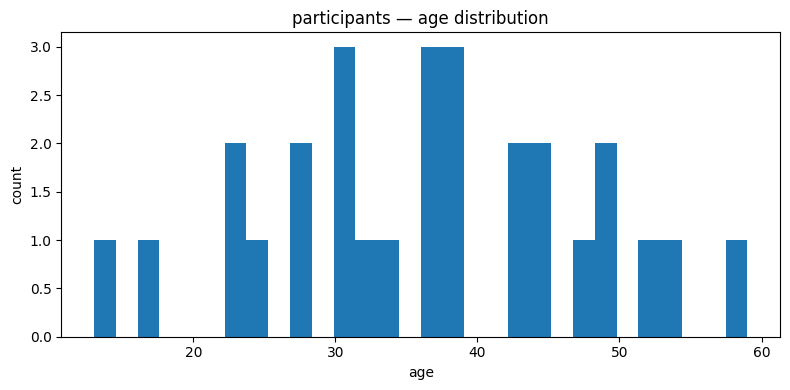

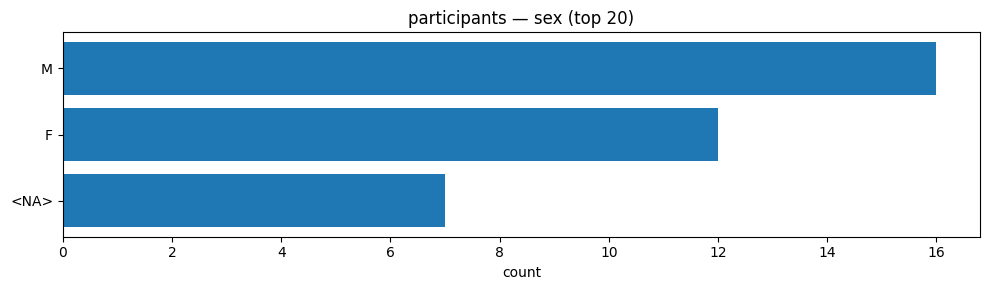

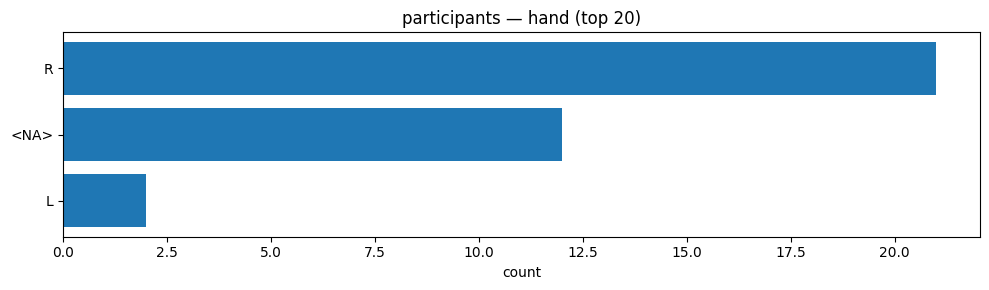

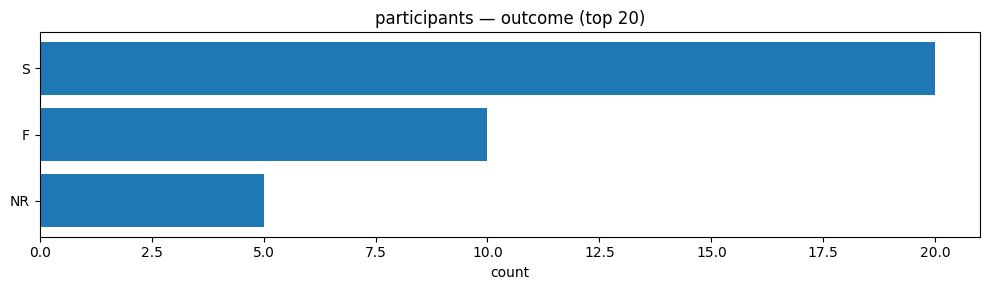

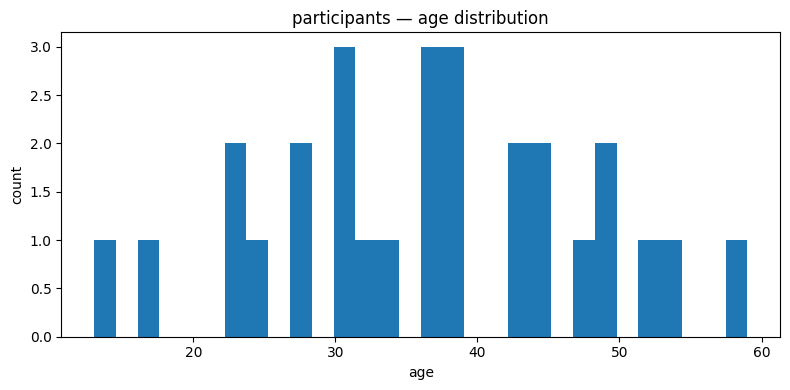

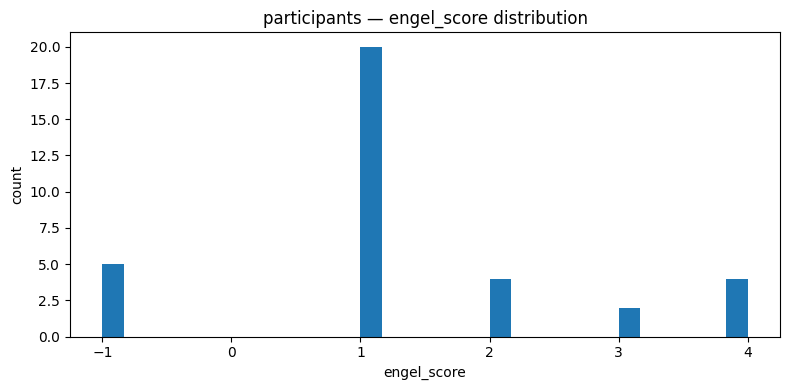

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
participant_id,35,35,sub-jh101,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,28.0,NaN,NaN,NaN,36.535714,11.272655,13.0,29.5,36.5,44.25,59.0
sex,28,2,M,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hand,23,2,R,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
outcome,35,3,S,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
engel_score,35.0,NaN,NaN,NaN,1.285714,1.384184,-1.0,1.0,1.0,2.0,4.0
ilae_score,35.0,NaN,NaN,NaN,1.657143,1.954525,-1.0,1.0,1.0,2.0,6.0
date_follow_up,1,1,2020-02-14,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ethnicity,18.0,NaN,NaN,NaN,0.833333,0.857493,0.0,0.0,1.0,1.75,2.0
years_follow_up,35.0,NaN,NaN,NaN,2.142857,1.682835,1.0,1.0,1.0,3.0,7.0


In [4]:
participants_tsv = DATASET_ROOT / 'participants.tsv'
participants = pd.read_csv(participants_tsv, sep='\t')
print('participants shape:', participants.shape)
display(participants.head())

print('columns:', list(participants.columns))

# --- Missingness plot (tỉ lệ missing theo cột)
missing_rate = (participants.isna().mean() * 100).sort_values(ascending=False)
plt.figure(figsize=(10, 4))
missing_rate.plot(kind='bar')
plt.ylabel('% missing')
plt.title('participants.tsv — Missingness by column')
plt.tight_layout()
plt.show()

# Helper plots (robust theo cột thực tế)
def plot_categorical_counts(df: pd.DataFrame, col: str, top_n: int = 20) -> None:
    if col not in df.columns:
        return
    s = df[col].astype('string').fillna('<NA>')
    vc = s.value_counts().head(top_n)
    plt.figure(figsize=(10, max(3, 0.3 * len(vc))))
    plt.barh(vc.index[::-1], vc.values[::-1])
    plt.title(f'participants — {col} (top {top_n})')
    plt.xlabel('count')
    plt.tight_layout()
    plt.show()


def plot_numeric_hist(df: pd.DataFrame, col: str, bins: int = 30) -> None:
    if col not in df.columns:
        return
    x = pd.to_numeric(df[col], errors='coerce').dropna()
    if len(x) == 0:
        return
    plt.figure(figsize=(8, 4))
    plt.hist(x, bins=bins)
    plt.title(f'participants — {col} distribution')
    plt.xlabel(col)
    plt.ylabel('count')
    plt.tight_layout()
    plt.show()

# Heuristics: thử plot một số cột phổ biến nếu tồn tại
candidate_cat_cols = [
    'sex','gender','handedness','institution','site','center','group','diagnosis','pathology',
    'participant_id',
 ]
candidate_num_cols = ['age','age_years','years','height','weight']

for c in candidate_cat_cols:
    if c in participants.columns:
        plot_categorical_counts(participants, c)

for c in candidate_num_cols:
    if c in participants.columns:
        plot_numeric_hist(participants, c)

# Nếu dataset không có các cột trên, tự động chọn vài cột category/numeric để plot
object_like = [c for c in participants.columns if participants[c].dtype == object]
numeric_like = [c for c in participants.columns if c not in object_like]

# Plot top 3 categorical columns (trừ participant_id vì quá nhiều unique)
for c in [c for c in object_like if c != 'participant_id'][:3]:
    plot_categorical_counts(participants, c)

# Plot top 2 numeric columns
for c in numeric_like[:2]:
    plot_numeric_hist(participants, c)

# Summary table
display(participants.describe(include='all').T)

## Phần 2 — Tổng quan signal (EDA metadata-level + plots)

Phần này **không cần đọc `.eeg`** (trừ khi bạn chạy Phần 3).

Mục tiêu:
- Tổng quan số run, acquisition (ECoG/SEEG), sampling frequency, số kênh, kênh bad/good
- Tổng quan event markers (`trial_type`) để biết cần chuẩn hóa label seizure thế nào
- Tạo `run_summary` và export CSV để lọc run tốt

In [5]:
# Parse run info từ basename dạng iEEG-BIDS
BIDS_RE = re.compile(
    r'^sub-(?P<subject>[^_]+)'
    r'(?:_ses-(?P<session>[^_]+))?'
    r'(?:_task-(?P<task>[^_]+))?'
    r'(?:_acq-(?P<acq>[^_]+))?'
    r'(?:_run-(?P<run>\d+))?'
    r'_(?P<suffix>ieeg)'
    r'$'
)


def parse_bids_basename(path: Path) -> dict:
    """Parse basename: sub-xxx(_ses-yyy)_task-zzz_acq-aaa_run-01_ieeg"""
    m = BIDS_RE.match(path.name)
    if not m:
        return {'subject': None, 'session': None, 'task': None, 'acq': None, 'run': None, 'suffix': None}
    d = m.groupdict()
    if d.get('run') is not None:
        d['run'] = int(d['run'])
    return d


# Tìm các sidecar iEEG trong toàn bộ dataset
events_paths = sorted(DATASET_ROOT.glob('sub-*/ses-*/ieeg/*_events.tsv'))
channels_paths = sorted(DATASET_ROOT.glob('sub-*/ses-*/ieeg/*_channels.tsv'))
ieeg_json_paths = sorted(DATASET_ROOT.glob('sub-*/ses-*/ieeg/*_ieeg.json'))
vhdr_paths = sorted(DATASET_ROOT.glob('sub-*/ses-*/ieeg/*_ieeg.vhdr'))
vmrk_paths = sorted(DATASET_ROOT.glob('sub-*/ses-*/ieeg/*_ieeg.vmrk'))
eeg_paths = sorted(DATASET_ROOT.glob('sub-*/ses-*/ieeg/*_ieeg.eeg'))

print('events:', len(events_paths))
print('channels:', len(channels_paths))
print('ieeg.json:', len(ieeg_json_paths))
print('vhdr:', len(vhdr_paths))
print('vmrk:', len(vmrk_paths))
print('eeg:', len(eeg_paths))

# Hiển thị vài ví dụ đường dẫn
print('\nExample events:', events_paths[:2])
print('Example channels:', channels_paths[:2])
print('Example vhdr:', vhdr_paths[:2])

events: 106
channels: 106
ieeg.json: 106
vhdr: 106
vmrk: 106
eeg: 106

Example events: [WindowsPath('EEG/ds003029/sub-jh101/ses-presurgery/ieeg/sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-01_events.tsv'), WindowsPath('EEG/ds003029/sub-jh101/ses-presurgery/ieeg/sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-02_events.tsv')]
Example channels: [WindowsPath('EEG/ds003029/sub-jh101/ses-presurgery/ieeg/sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-01_channels.tsv'), WindowsPath('EEG/ds003029/sub-jh101/ses-presurgery/ieeg/sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-02_channels.tsv')]
Example vhdr: [WindowsPath('EEG/ds003029/sub-jh101/ses-presurgery/ieeg/sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.vhdr'), WindowsPath('EEG/ds003029/sub-jh101/ses-presurgery/ieeg/sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-02_ieeg.vhdr')]


### 2.1) Tạo `run_summary` (sidecar-level, không cần đọc `.eeg`)

Cell này sẽ:
- Ghép `events.tsv` + `channels.tsv` + `ieeg.json` theo từng run
- Trích xuất seizure onset/offset (heuristic bằng regex; có thể chỉnh sau khi xem event vocab)
- Tính số kênh good/bad và thống kê type (ECOG/SEEG/ECG...)
- Đánh dấu `eeg_content_present` (có content thật hay chỉ là annex placeholder)

In [6]:
# Expand regex to match common marker strings in ds003029
# - Onset examples seen: "SZ EVENT # (EEG SZ)"
# - Offset examples seen: "Z ELECTROGRAPHIC END"
ONSETS_RE = re.compile(r'(?i)(?:\bonset\b|sz\s*onset|seizure\s*onset|\bsz\s*event\b|eeg\s*sz)')
OFFSETS_RE = re.compile(r'(?i)(?:\boffset\b|sz\s*offset|seizure\s*offset|electrographic\s*end)')

import subprocess

def annex_present_relpaths() -> set[str]:
    """Return set of annexed file paths whose CONTENT is present in `here`.
    
    Uses one git-annex call (fast) instead of per-file checks.
    Paths returned are relative to DATASET_ROOT and normalized to POSIX slashes.
    """
    try:
        res = subprocess.run(
            ['git', 'annex', 'find', '-i', 'here', '--format=${file}\n'],
            cwd=str(DATASET_ROOT),
            capture_output=True,
            text=True,
        )
        out = (res.stdout or '').splitlines()
        return {line.strip().lstrip('./').replace('\\', '/') for line in out if line.strip()}
    except FileNotFoundError:
        return set()


def base_from_sidecar(path: Path) -> Path:
    """Convert sidecar path to a common base name ending with *_ieeg (no extension)."""
    name = path.name
    name = re.sub(r'_(events|channels|ieeg)\.(tsv|json)$', '_ieeg', name)
    name = re.sub(r'_ieeg\.(vhdr|vmrk|eeg)$', '_ieeg', name)
    return path.with_name(name)


def index_by_base(paths: list[Path]) -> dict[str, Path]:
    out: dict[str, Path] = {}
    for p in paths:
        out[str(base_from_sidecar(p))] = p
    return out


def safe_read_tsv(path: Path) -> pd.DataFrame | None:
    if path is None or (not path.exists()):
        return None
    return pd.read_csv(path, sep='\t')


def safe_read_json(path: Path) -> dict | None:
    if path is None or (not path.exists()):
        return None
    return json.loads(path.read_text(encoding='utf-8'))


events_by_base = index_by_base(events_paths)
channels_by_base = index_by_base(channels_paths)
ieeg_json_by_base = index_by_base(ieeg_json_paths)
vhdr_by_base = index_by_base(vhdr_paths)
vmrk_by_base = index_by_base(vmrk_paths)
eeg_by_base = index_by_base(eeg_paths)

all_bases = sorted(set(events_by_base) | set(channels_by_base) | set(ieeg_json_by_base) | set(vhdr_by_base) | set(vmrk_by_base))
print('unique runs (bases):', len(all_bases))

# Precompute which annexed files are present locally
present_set = annex_present_relpaths()
print('annex-present files (here):', len(present_set))
if len(present_set) == 0:
    print('Note: git-annex not available (or nothing present). Will fall back to size heuristic for *.eeg.')

summary_rows: list[dict] = []
for base in all_bases:
    base_path = Path(base)
    meta = parse_bids_basename(base_path)

    events_p = events_by_base.get(base)
    channels_p = channels_by_base.get(base)
    ieeg_json_p = ieeg_json_by_base.get(base)

    channels = safe_read_tsv(channels_p) if channels_p else None
    events = safe_read_tsv(events_p) if events_p else None
    ieeg_meta = safe_read_json(ieeg_json_p) if ieeg_json_p else None
    ieeg_meta = ieeg_meta or {}

    n_channels = int(channels.shape[0]) if channels is not None else np.nan
    n_good = int((channels['status'] == 'good').sum()) if channels is not None and 'status' in channels else np.nan
    n_bad = int((channels['status'] == 'bad').sum()) if channels is not None and 'status' in channels else np.nan

    type_counts = {}
    if channels is not None and 'type' in channels:
        type_counts = channels['type'].value_counts().to_dict()

    sfreq = ieeg_meta.get('SamplingFrequency', np.nan)
    line_freq = ieeg_meta.get('PowerLineFrequency', np.nan)
    if (sfreq is np.nan or sfreq != sfreq) and channels is not None and 'sampling_frequency' in channels:
        tmp = pd.to_numeric(channels['sampling_frequency'], errors='coerce').dropna()
        if len(tmp) > 0:
            sfreq = float(tmp.iloc[0])

    seizure_onset_s = np.nan
    seizure_offset_s = np.nan
    seizure_duration_s = np.nan
    has_onset = False
    has_offset = False

    if events is not None and 'trial_type' in events and 'onset' in events:
        tt = events['trial_type'].astype(str)
        onset_mask = tt.apply(lambda x: bool(ONSETS_RE.search(x))) & ~tt.apply(lambda x: bool(OFFSETS_RE.search(x)))
        offset_mask = tt.apply(lambda x: bool(OFFSETS_RE.search(x)))

        onsets = pd.to_numeric(events.loc[onset_mask, 'onset'], errors='coerce').dropna().sort_values()
        offsets = pd.to_numeric(events.loc[offset_mask, 'onset'], errors='coerce').dropna().sort_values()

        has_onset = len(onsets) > 0
        has_offset = len(offsets) > 0

        if has_onset:
            seizure_onset_s = float(onsets.iloc[0])
            if has_offset:
                later_offsets = offsets[offsets > seizure_onset_s]
                if len(later_offsets) > 0:
                    seizure_offset_s = float(later_offsets.iloc[0])
                    seizure_duration_s = float(seizure_offset_s - seizure_onset_s)

    eeg_worktree_exists = False
    eeg_size = np.nan
    eeg_content_present = False
    eeg_p = eeg_by_base.get(base)
    if eeg_p and Path(eeg_p).exists():
        eeg_worktree_exists = True
        try:
            eeg_size = Path(eeg_p).stat().st_size
        except Exception:
            eeg_size = np.nan

        # Reliable: check presence via git-annex find -i here (precomputed)
        try:
            rel = Path(eeg_p).relative_to(DATASET_ROOT).as_posix()
        except Exception:
            rel = str(Path(eeg_p)).replace('\\', '/')
        if len(present_set) > 0:
            eeg_content_present = rel in present_set
        else:
            # Fallback heuristic: placeholder files are usually tiny
            eeg_content_present = (eeg_size is not np.nan) and (float(eeg_size) > 1024 * 1024)

    # Backward-compatible column name (previously used a size>0 heuristic)
    eeg_present = bool(eeg_content_present)

    summary_rows.append({
        **meta,
        'base': base,
        'events_tsv': str(events_p) if events_p else '',
        'channels_tsv': str(channels_p) if channels_p else '',
        'ieeg_json': str(ieeg_json_p) if ieeg_json_p else '',
        'vhdr': str(vhdr_by_base.get(base, '')),
        'vmrk': str(vmrk_by_base.get(base, '')),
        'eeg': str(eeg_p) if eeg_p else '',
        'n_channels': n_channels,
        'n_good': n_good,
        'n_bad': n_bad,
        'type_counts': type_counts,
        'sfreq': sfreq,
        'line_freq': line_freq,
        'has_onset': has_onset,
        'has_offset': has_offset,
        'seizure_onset_s': seizure_onset_s,
        'seizure_offset_s': seizure_offset_s,
        'seizure_duration_s': seizure_duration_s,
        'eeg_worktree_exists': eeg_worktree_exists,
        'eeg_content_present': eeg_content_present,
        'eeg_present': eeg_present,
        'eeg_size_bytes': eeg_size,
    })

run_summary = pd.DataFrame(summary_rows)
print('runs:', len(run_summary))
print('runs with onset:', int(run_summary['has_onset'].sum()))
print('runs with onset+offset:', int((run_summary['has_onset'] & run_summary['has_offset']).sum()))
print('runs with eeg content present:', int(run_summary['eeg_content_present'].sum()))

display(run_summary.head())

unique runs (bases): 106
annex-present files (here): 48
runs: 106
runs with onset: 103
runs with onset+offset: 73
runs with eeg content present: 16


,subject,session,task,acq,run,suffix,base,events_tsv,channels_tsv,ieeg_json,...,line_freq,has_onset,has_offset,seizure_onset_s,seizure_offset_s,seizure_duration_s,eeg_worktree_exists,eeg_content_present,eeg_present,eeg_size_bytes
0,jh101,presurgery,ictal,ecog,1,ieeg,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,...,60,True,True,58.950,79.875,20.925,True,True,True,76788000
1,jh101,presurgery,ictal,ecog,2,ieeg,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,...,60,True,True,66.825,275.850,209.025,True,True,True,182614500
2,jh101,presurgery,ictal,ecog,3,ieeg,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,...,60,True,True,58.950,79.875,20.925,True,True,True,76788000
3,jh101,presurgery,ictal,ecog,4,ieeg,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,...,60,True,True,58.950,84.825,25.875,True,False,False,69
4,jh102,presurgery,ictal,ecog,1,ieeg,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...,...,60,True,True,54.834,333.944,279.110,True,True,True,189942012


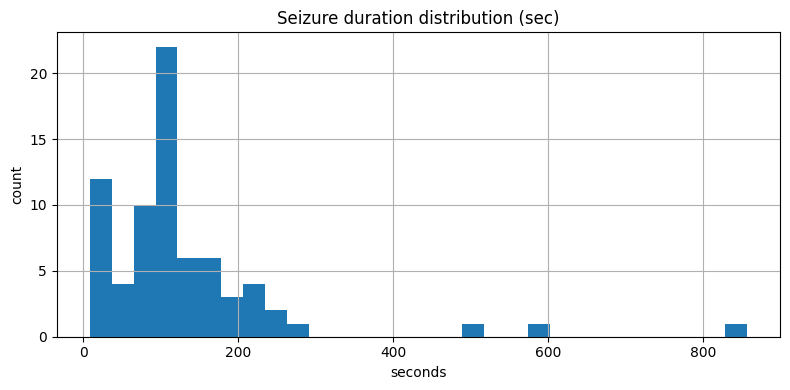

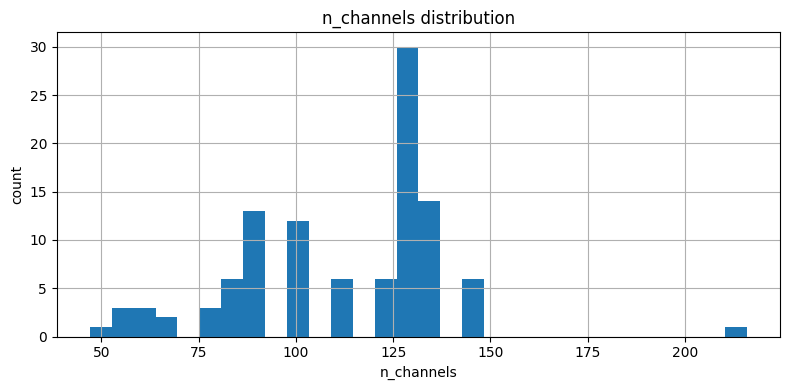

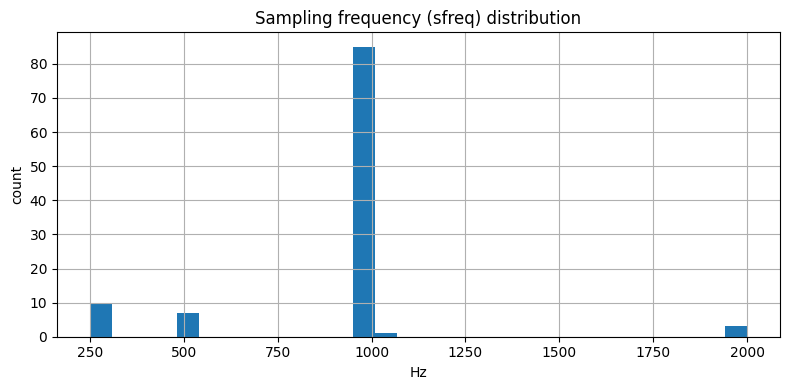

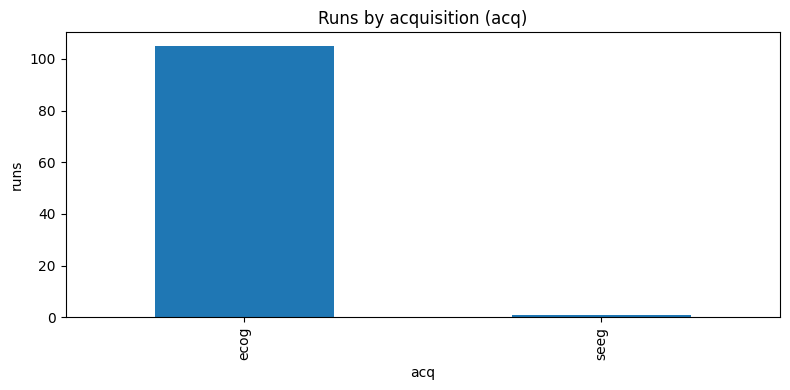

,has_onset,has_offset,has_onset+offset,eeg_content_present,onset+offset+eeg
0,103,73,73,16,16


,acq,runs,onset_runs,onset_offset_runs,eeg_present_runs,median_channels,median_bad
0,ecog,105,102,73,16,123.0,19.0
1,seeg,1,1,0,0,129.0,91.0


,subject,acq,run,sfreq,n_channels,n_bad,seizure_onset_s,seizure_offset_s,seizure_duration_s,eeg_content_present
0,jh101,ecog,1,1000.000000,135,26,58.95000,79.875000,20.925000,True
1,jh101,ecog,2,1000.000000,135,26,66.82500,275.850000,209.025000,True
2,jh101,ecog,3,1000.000000,135,26,58.95000,79.875000,20.925000,True
65,pt3,ecog,2,1000.000000,135,36,109.57500,226.800000,117.225000,True
44,pt13,ecog,1,1000.000000,132,13,68.08000,77.280000,9.200000,True
45,pt13,ecog,2,1000.000000,132,13,71.07000,80.500000,9.430000,True
80,ummc001,ecog,1,499.707104,129,42,31.00016,132.999910,101.999751,True
81,ummc001,ecog,2,499.707104,129,42,31.00016,141.000597,110.000437,True
4,jh102,ecog,1,1000.000000,123,8,54.83400,333.944000,279.110000,True
5,jh102,ecog,2,1000.000000,123,8,59.77400,227.000000,167.226000,True


In [7]:
# 2.2) Plots nhanh từ run_summary
rs = run_summary.copy()

# Backward compatible: column names
eeg_present_col = 'eeg_content_present' if 'eeg_content_present' in rs.columns else ('eeg_present' if 'eeg_present' in rs.columns else None)
if eeg_present_col is None:
    raise KeyError('run_summary thiếu cột eeg_content_present/eeg_present. Hãy rebuild run_summary (Phần 2.1).')

# Distribution: seizure duration (nếu có)
plt.figure(figsize=(8, 4))
rs['seizure_duration_s'].dropna().hist(bins=30)
plt.title('Seizure duration distribution (sec)')
plt.xlabel('seconds')
plt.ylabel('count')
plt.tight_layout()
plt.show()

# Distribution: number of channels
plt.figure(figsize=(8, 4))
pd.to_numeric(rs['n_channels'], errors='coerce').dropna().hist(bins=30)
plt.title('n_channels distribution')
plt.xlabel('n_channels')
plt.ylabel('count')
plt.tight_layout()
plt.show()

# Distribution: sampling frequency
plt.figure(figsize=(8, 4))
pd.to_numeric(rs['sfreq'], errors='coerce').dropna().hist(bins=30)
plt.title('Sampling frequency (sfreq) distribution')
plt.xlabel('Hz')
plt.ylabel('count')
plt.tight_layout()
plt.show()

# Run counts by acquisition
plt.figure(figsize=(8, 4))
rs['acq'].fillna('<NA>').value_counts().plot(kind='bar')
plt.title('Runs by acquisition (acq)')
plt.ylabel('runs')
plt.tight_layout()
plt.show()

# Coverage: onset/offset + eeg content
coverage = pd.DataFrame({
    'has_onset': [int(rs['has_onset'].astype(bool).sum())],
    'has_offset': [int(rs['has_offset'].astype(bool).sum())],
    'has_onset+offset': [int((rs['has_onset'].astype(bool) & rs['has_offset'].astype(bool)).sum())],
    eeg_present_col: [int(rs[eeg_present_col].astype(bool).sum())],
    'onset+offset+eeg': [int((rs['has_onset'].astype(bool) & rs['has_offset'].astype(bool) & rs[eeg_present_col].astype(bool)).sum())],
})
display(coverage)

# Summary by acquisition (ECoG vs SEEG)
rs['_has_onset_offset'] = rs['has_onset'].astype(bool) & rs['has_offset'].astype(bool)
summary_by_acq = (
    rs.assign(acq=rs['acq'].fillna('<NA>'))
    .groupby('acq', dropna=False)
    .agg(
        runs=('base', 'count'),
        onset_runs=('has_onset', lambda s: int(pd.Series(s).astype(bool).sum())),
        onset_offset_runs=('_has_onset_offset', lambda s: int(pd.Series(s).astype(bool).sum())),
        eeg_present_runs=(eeg_present_col, lambda s: int(pd.Series(s).astype(bool).sum())),
        median_channels=('n_channels', 'median'),
        median_bad=('n_bad', 'median'),
    )
    .reset_index()
 )

display(summary_by_acq)

# Xem một số run "đẹp" (có onset+offset)
display(
    rs[rs['has_onset'].astype(bool) & rs['has_offset'].astype(bool)]
    .sort_values([eeg_present_col, 'n_channels'], ascending=[False, False])
    .head(20)
    [['subject','acq','run','sfreq','n_channels','n_bad','seizure_onset_s','seizure_offset_s','seizure_duration_s',eeg_present_col]]
 )

### 2.3) Event vocabulary (trial_type)

Mục tiêu:
- Xem các chuỗi marker phổ biến trong `trial_type`
- Dùng thông tin này để tinh chỉnh regex `ONSETS_RE` / `OFFSETS_RE` cho seizure onset/offset

,trial_type,count
0,+0.000000,75
1,A1+A2 OFF,69
2,offset,32
3,Schedule,29
4,sz onset,27
5,sz offset,26
6,onset,19
7,SZ EVENT # (PB SZ),19
8,+59.000000,17
9,Segment: REC START REC EEG,17


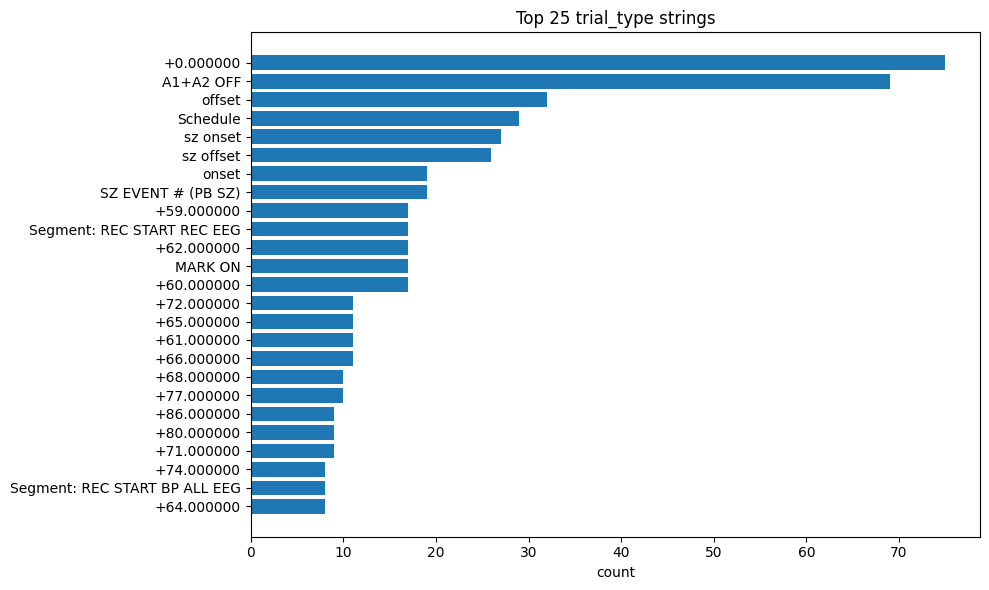

In [8]:
trial_types: list[str] = []
for p in events_paths:
    df = pd.read_csv(p, sep='\t')
    if 'trial_type' in df:
        trial_types.extend(df['trial_type'].astype(str).tolist())

event_vocab = (
    pd.Series(trial_types)
    .value_counts()
    .rename_axis('trial_type')
    .reset_index(name='count')
)

display(event_vocab.head(40))

top_n = 25
plt.figure(figsize=(10, 6))
plt.barh(event_vocab.head(top_n)['trial_type'][::-1], event_vocab.head(top_n)['count'][::-1])
plt.title(f'Top {top_n} trial_type strings')
plt.xlabel('count')
plt.tight_layout()
plt.show()

### 2.4) Export outputs

Xuất các bảng EDA ra `eda_outputs/`:
- `ds003029_run_summary.csv`
- `ds003029_event_vocab.csv`

In [9]:
out_dir = Path('eda_outputs')
out_dir.mkdir(exist_ok=True)

run_summary_out = out_dir / 'ds003029_run_summary.csv'
event_vocab_out = out_dir / 'ds003029_event_vocab.csv'

run_summary.to_csv(run_summary_out, index=False)
event_vocab.to_csv(event_vocab_out, index=False)

print('Wrote:', run_summary_out.resolve())
print('Wrote:', event_vocab_out.resolve())

Wrote: C:\Users\LENOVO\Downloads\eeg\eda_outputs\ds003029_run_summary.csv
Wrote: C:\Users\LENOVO\Downloads\eeg\eda_outputs\ds003029_event_vocab.csv


### 2.5) Chọn 10–15 run để `git annex get` (ưu tiên seizure onset/offset)

Mục tiêu: tạo shortlist các run để tải dữ liệu thật (`.eeg/.vhdr/.vmrk`) phục vụ **EDA signal-level & seizure detection**.

Tiêu chí chọn (theo thứ tự ưu tiên):
- Có seizure onset **và** offset (từ `events.tsv` bằng regex)
- Nhiều kênh hơn (thường hữu ích cho phân tích)
- Đa dạng subject (tránh chọn quá nhiều run từ 1 subject)
- Ưu tiên những run **chưa có** `eeg_content_present` (để bạn tải thêm dữ liệu)

In [10]:
# Shortlist runs for downloading real EEG content (BrainVision .vhdr/.vmrk/.eeg)
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd

# Make this cell runnable even after a kernel restart
if 'DATASET_ROOT' not in globals():
    DATASET_ROOT = Path('EEG') / 'ds003029'
assert DATASET_ROOT.exists(), f'Không thấy dataset tại: {DATASET_ROOT.resolve()}'

if 'run_summary' not in globals():
    # Fallback: load from exported CSV if available
    run_summary_csv = Path('eda_outputs') / 'ds003029_run_summary.csv'
    if run_summary_csv.exists():
        run_summary = pd.read_csv(run_summary_csv)
        print('Loaded run_summary from:', run_summary_csv.resolve())
    else:
        raise AssertionError(
            'Chưa có run_summary trong kernel. '
            'Hãy chạy Cell 8 (Phần 2.1) để tạo run_summary, hoặc chạy Cell 13 (Phần 2.4) để export rồi chạy lại cell này.'
        )

rs = run_summary.copy()

# Backward compatible: column names
eeg_present_col = 'eeg_content_present' if 'eeg_content_present' in rs.columns else ('eeg_present' if 'eeg_present' in rs.columns else None)
if eeg_present_col is None:
    raise KeyError('run_summary thiếu cột eeg_content_present/eeg_present. Hãy rebuild run_summary (Phần 2.1).')

# Compute a score to rank candidates
def _safe_num(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors='coerce')

rs['_sfreq'] = _safe_num(rs.get('sfreq', pd.Series([np.nan] * len(rs))))
rs['_n_channels'] = _safe_num(rs.get('n_channels', pd.Series([np.nan] * len(rs))))
rs['_n_bad'] = _safe_num(rs.get('n_bad', pd.Series([np.nan] * len(rs))))

# Prefer seizure markers, more channels, fewer bad channels, known acq
rs['_score'] = 0.0
rs.loc[rs.get('has_onset', False).astype(bool), '_score'] += 10
rs.loc[(rs.get('has_onset', False).astype(bool) & rs.get('has_offset', False).astype(bool)), '_score'] += 15
rs['_score'] += rs['_n_channels'].fillna(0) / 50.0
rs['_score'] -= rs['_n_bad'].fillna(0) / 50.0
rs.loc[rs.get('acq', '').astype(str).str.lower().isin(['ecog', 'seeg']), '_score'] += 2

# Prefer runs not yet downloaded (so your next git-annex get adds value)
rs['_already_downloaded'] = rs[eeg_present_col].astype(bool)
rs.loc[~rs['_already_downloaded'], '_score'] += 3

# Filter for runs that have a base
rs['base'] = rs['base'].astype(str)
rs = rs[rs['base'].str.len() > 0].copy()

def files_for_base(base: str) -> dict[str, Path]:
    base_p = Path(base)
    return {
        'vhdr': Path(str(base_p) + '.vhdr'),
        'vmrk': Path(str(base_p) + '.vmrk'),
        'eeg':  Path(str(base_p) + '.eeg'),
    }

def rel_to_dataset_root(p: Path) -> str:
    # Return a path suitable to run inside DATASET_ROOT
    try:
        return p.relative_to(DATASET_ROOT).as_posix()
    except Exception:
        return str(p).replace('\\', '/')

# Candidate pool: prioritize seizure-window runs first
pool1 = rs[rs.get('has_onset', False).astype(bool) & rs.get('has_offset', False).astype(bool)].copy()
pool2 = rs[rs.get('has_onset', False).astype(bool) & ~rs.get('has_offset', False).astype(bool)].copy()
pool3 = rs.copy()

def select_diverse(df: pd.DataFrame, n: int, max_per_subject: int = 2) -> pd.DataFrame:
    df = df.sort_values(['_score', '_n_channels'], ascending=[False, False]).copy()
    chosen = []
    per_subj: dict[str, int] = {}
    for _, row in df.iterrows():
        subj = str(row.get('subject', ''))
        per_subj.setdefault(subj, 0)
        if per_subj[subj] >= max_per_subject:
            continue
        chosen.append(row)
        per_subj[subj] += 1
        if len(chosen) >= n:
            break
    if len(chosen) == 0:
        return df.head(0)
    return pd.DataFrame(chosen)

N = 15
selected = select_diverse(pool1, n=min(N, len(pool1)), max_per_subject=2)
if len(selected) < 10:
    need = 10 - len(selected)
    add = select_diverse(pool2[~pool2.index.isin(selected.index)], n=need, max_per_subject=2)
    selected = pd.concat([selected, add], ignore_index=False)
if len(selected) < 10:
    need = 10 - len(selected)
    add = select_diverse(pool3[~pool3.index.isin(selected.index)], n=need, max_per_subject=2)
    selected = pd.concat([selected, add], ignore_index=False)

# Cap at 15 if we got more
selected = selected.sort_values(['_score', '_n_channels'], ascending=[False, False]).head(N).copy()

cols_show = ['subject','session','task','acq','run','sfreq','n_channels','n_bad','has_onset','has_offset','seizure_onset_s','seizure_offset_s','seizure_duration_s',eeg_present_col,'base']
cols_show = [c for c in cols_show if c in selected.columns]
print(f'Selected runs: {len(selected)} (target 10–15)')
display(selected[cols_show])

# Build git-annex get commands (run within DATASET_ROOT)
print('\nSuggested commands (run inside EEG/ds003029):')
print('cd', DATASET_ROOT.as_posix())
for _, row in selected.iterrows():
    base = str(row['base'])
    files = files_for_base(base)
    rels = [rel_to_dataset_root(files[k]) for k in ['vhdr','vmrk','eeg']]
    print('git annex get ' + ' '.join(rels))

already = int(selected[eeg_present_col].astype(bool).sum()) if eeg_present_col in selected.columns else 0
print(f'\nAlready downloaded among selected: {already}/{len(selected)}')

Selected runs: 15 (target 10–15)


,subject,session,task,acq,run,sfreq,n_channels,n_bad,has_onset,has_offset,seizure_onset_s,seizure_offset_s,seizure_duration_s,eeg_content_present,base
46,pt13,presurgery,ictal,ecog,3,1000.000000,132,13,True,True,77.740000,86.250000,8.510000,False,EEG\ds003029\sub-pt13\ses-presurgery\ieeg\sub-...
47,pt13,presurgery,ictal,ecog,4,1000.000000,132,13,True,True,67.390000,77.050000,9.660000,False,EEG\ds003029\sub-pt13\ses-presurgery\ieeg\sub-...
3,jh101,presurgery,ictal,ecog,4,1000.000000,135,26,True,True,58.950000,84.825000,25.875000,False,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...
71,pt7,presurgery,ictal,ecog,3,1000.000000,111,15,True,True,150.426000,212.350000,61.924000,False,EEG\ds003029\sub-pt7\ses-presurgery\ieeg\sub-p...
82,ummc001,presurgery,ictal,ecog,3,499.707104,129,42,True,True,63.000905,155.000798,91.999893,False,EEG\ds003029\sub-ummc001\ses-presurgery\ieeg\s...
33,pt01,presurgery,ictal,ecog,3,1000.000000,98,12,True,True,108.810000,272.800000,163.990000,False,EEG\ds003029\sub-pt01\ses-presurgery\ieeg\sub-...
34,pt01,presurgery,ictal,ecog,4,1000.000000,98,12,True,True,127.720000,219.790000,92.070000,False,EEG\ds003029\sub-pt01\ses-presurgery\ieeg\sub-...
66,pt6,presurgery,ictal,ecog,1,1000.000000,99,17,True,True,120.958000,228.715000,107.757000,False,EEG\ds003029\sub-pt6\ses-presurgery\ieeg\sub-p...
67,pt6,presurgery,ictal,ecog,2,1000.000000,99,17,True,True,169.464000,275.379000,105.915000,False,EEG\ds003029\sub-pt6\ses-presurgery\ieeg\sub-p...
38,pt11,presurgery,ictal,ecog,1,1000.000000,132,52,True,True,60.260000,116.380000,56.120000,False,EEG\ds003029\sub-pt11\ses-presurgery\ieeg\sub-...



Suggested commands (run inside EEG/ds003029):
cd EEG/ds003029
git annex get sub-pt13/ses-presurgery/ieeg/sub-pt13_ses-presurgery_task-ictal_acq-ecog_run-03_ieeg.vhdr sub-pt13/ses-presurgery/ieeg/sub-pt13_ses-presurgery_task-ictal_acq-ecog_run-03_ieeg.vmrk sub-pt13/ses-presurgery/ieeg/sub-pt13_ses-presurgery_task-ictal_acq-ecog_run-03_ieeg.eeg
git annex get sub-pt13/ses-presurgery/ieeg/sub-pt13_ses-presurgery_task-ictal_acq-ecog_run-04_ieeg.vhdr sub-pt13/ses-presurgery/ieeg/sub-pt13_ses-presurgery_task-ictal_acq-ecog_run-04_ieeg.vmrk sub-pt13/ses-presurgery/ieeg/sub-pt13_ses-presurgery_task-ictal_acq-ecog_run-04_ieeg.eeg
git annex get sub-jh101/ses-presurgery/ieeg/sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-04_ieeg.vhdr sub-jh101/ses-presurgery/ieeg/sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-04_ieeg.vmrk sub-jh101/ses-presurgery/ieeg/sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-04_ieeg.eeg
git annex get sub-pt7/ses-presurgery/ieeg/sub-pt7_ses-presurgery_task-ictal_acq-ec

## Phần 3 — Visualize 1 case signal (BrainVision)

Phần này sẽ đọc BrainVision (`*.vhdr` + `*.eeg` + `*.vmrk`) để:
- plot waveform một vài kênh quanh seizure (nếu tìm được onset/offset)
- plot PSD nhanh

Yêu cầu trước khi chạy:
- Bạn đã `git annex get` ít nhất 1 run: `.eeg`, `.vhdr`, `.vmrk`
- Xem hướng dẫn trong **`huong_dan_get_du_lieu_ds003029.md`**

Nếu bạn chưa cài `mne` và `scipy`, chạy cell import ngay bên dưới (sẽ báo lỗi nếu thiếu).

In [11]:
# Nếu lỗi ImportError: hãy cài trong env đang chạy notebook:
# pip install mne scipy
import mne
from scipy.signal import welch

In [12]:
from __future__ import annotations

from pathlib import Path

def is_valid_brainvision_vhdr(vhdr_path: Path) -> bool:
    """Quick sanity check: BrainVision header must contain a [Common Infos] section."""
    try:
        text = vhdr_path.read_text(encoding='utf-8', errors='ignore')
    except Exception:
        return False
    # Typical BrainVision: [Common Infos]; MNE also has a workaround for [Common infos]
    return ('[Common Infos]' in text) or ('[Common infos]' in text)


def preview_text(path: Path, n_lines: int = 40) -> str:
    try:
        lines = path.read_text(encoding='utf-8', errors='ignore').splitlines()
    except Exception as e:
        return f'<cannot read text: {e}>'
    return '\n'.join(lines[:n_lines])


print('Signal-level EDA prerequisites:')
print('- You need actual *.eeg content for the selected run (not annex placeholders).')
print('- Some runs may have non-standard/invalid *.vhdr; we will skip those automatically.')

Signal-level EDA prerequisites:
- You need actual *.eeg content for the selected run (not annex placeholders).
- Some runs may have non-standard/invalid *.vhdr; we will skip those automatically.


Selection mode: seizure-window
runs with eeg content present: 16
runs with onset+offset AND eeg content present: 16


,subject,acq,run,sfreq,n_channels,n_bad,has_onset,has_offset,seizure_onset_s,seizure_offset_s,seizure_duration_s,vhdr,eeg
0,jh101,ecog,1,1000.000000,135,26,True,True,58.95000,79.875000,20.925000,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...
1,jh101,ecog,2,1000.000000,135,26,True,True,66.82500,275.850000,209.025000,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...
2,jh101,ecog,3,1000.000000,135,26,True,True,58.95000,79.875000,20.925000,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...
65,pt3,ecog,2,1000.000000,135,36,True,True,109.57500,226.800000,117.225000,EEG\ds003029\sub-pt3\ses-presurgery\ieeg\sub-p...,EEG\ds003029\sub-pt3\ses-presurgery\ieeg\sub-p...
44,pt13,ecog,1,1000.000000,132,13,True,True,68.08000,77.280000,9.200000,EEG\ds003029\sub-pt13\ses-presurgery\ieeg\sub-...,EEG\ds003029\sub-pt13\ses-presurgery\ieeg\sub-...
45,pt13,ecog,2,1000.000000,132,13,True,True,71.07000,80.500000,9.430000,EEG\ds003029\sub-pt13\ses-presurgery\ieeg\sub-...,EEG\ds003029\sub-pt13\ses-presurgery\ieeg\sub-...
81,ummc001,ecog,2,499.707104,129,42,True,True,31.00016,141.000597,110.000437,EEG\ds003029\sub-ummc001\ses-presurgery\ieeg\s...,EEG\ds003029\sub-ummc001\ses-presurgery\ieeg\s...
80,ummc001,ecog,1,499.707104,129,42,True,True,31.00016,132.999910,101.999751,EEG\ds003029\sub-ummc001\ses-presurgery\ieeg\s...,EEG\ds003029\sub-ummc001\ses-presurgery\ieeg\s...
4,jh102,ecog,1,1000.000000,123,8,True,True,54.83400,333.944000,279.110000,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...
5,jh102,ecog,2,1000.000000,123,8,True,True,59.77400,227.000000,167.226000,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...


---
Trying VHDR: EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.vhdr
EEG: EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.eeg
Loaded OK: <RawBrainVision | sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.eeg, 135 x 142200 (142.2 s), ~139 kB, data not loaded>
Reading 0 ... 139875  =      0.000 ...   139.875 secs...
Picked channels: ['LAF1', 'LAF2', 'LAF3', 'LAF4', 'LAF5', 'LAF6', 'LAF7', 'LAF8', 'LAT1', 'LAT2']


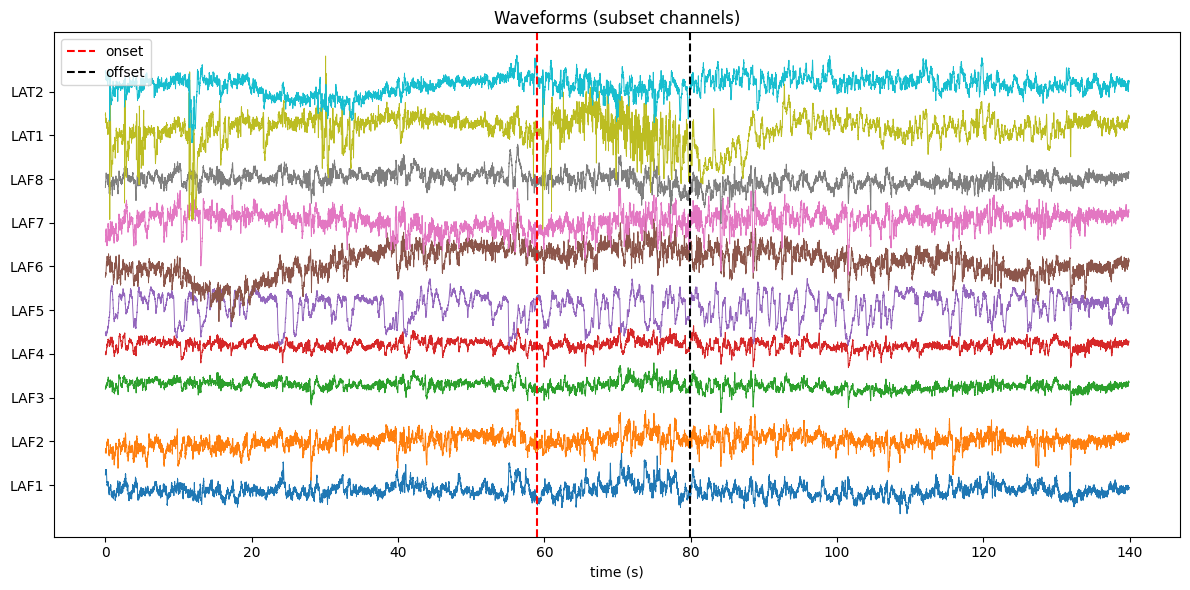

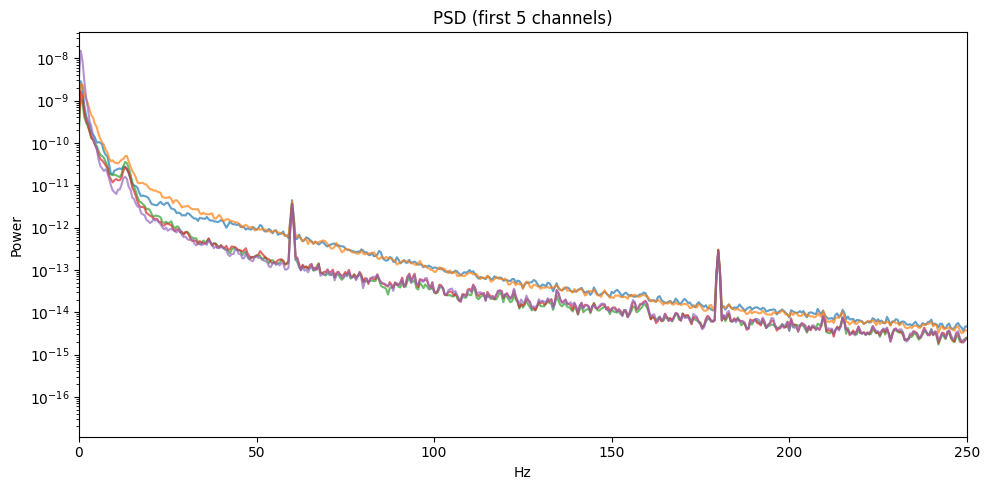

In [13]:
# Chọn 1 run để load BrainVision và plot waveform/PSD
assert 'base' in run_summary.columns, 'run_summary thiếu cột base. Hãy chạy lại Cell 8 để rebuild run_summary.'

eeg_present_col = 'eeg_content_present' if 'eeg_content_present' in run_summary.columns else 'eeg_present'
if eeg_present_col not in run_summary.columns:
    raise KeyError('run_summary thiếu cả eeg_content_present và eeg_present. Hãy chạy lại Cell 8.')

# 1) Ưu tiên run có onset+offset + eeg content present
seizure_candidate = run_summary[run_summary['has_onset'] & run_summary['has_offset'] & run_summary[eeg_present_col]].copy()

# 2) Fallback: nếu chưa có overlap (vì regex marker chưa khớp), dùng bất kỳ run nào có eeg content present để vẫn xem được signal
content_candidate = run_summary[run_summary[eeg_present_col]].copy()

if len(seizure_candidate) > 0:
    candidate = seizure_candidate
    mode = 'seizure-window'
else:
    candidate = content_candidate
    mode = 'no-seizure-markers (fallback)'

print('Selection mode:', mode)
print('runs with eeg content present:', int(content_candidate.shape[0]))
print('runs with onset+offset AND eeg content present:', int(seizure_candidate.shape[0]))

assert len(candidate) > 0, (
    'Không có run nào có eeg_content_present=1. '
    'Hãy đảm bảo bạn đã git annex get đúng file *.eeg rồi chạy lại Cell 8.'
 )

# Luôn suy ra các đường dẫn từ `base` để tránh lỗi KeyError do kernel giữ DataFrame cũ/mất cột
base_s = candidate['base'].astype(str)
vhdr_s = base_s + '.vhdr'
eeg_s = base_s + '.eeg'
vmrk_s = base_s + '.vmrk'
events_s = base_s.str.replace('_ieeg$', '_events.tsv', regex=True)
channels_s = base_s.str.replace('_ieeg$', '_channels.tsv', regex=True)

# Filter theo VHDR tồn tại + hợp lệ
vhdr_nonempty = vhdr_s.astype(str).str.len() > 0
vhdr_exists = vhdr_s.apply(lambda p: Path(p).exists())
vhdr_valid = vhdr_s.apply(lambda p: is_valid_brainvision_vhdr(Path(p)))
keep = vhdr_nonempty & vhdr_exists & vhdr_valid
candidate = candidate[keep].copy()

# Gắn lại các cột path sau khi filter (để các đoạn code bên dưới dùng thống nhất)
candidate = candidate.assign(
    vhdr=vhdr_s.loc[candidate.index].values,
    eeg=eeg_s.loc[candidate.index].values,
    vmrk=vmrk_s.loc[candidate.index].values,
    events_tsv=events_s.loc[candidate.index].values,
    channels_tsv=channels_s.loc[candidate.index].values,
 )

display(
    candidate.sort_values(['n_channels'], ascending=False)
    .head(15)
    [['subject','acq','run','sfreq','n_channels','n_bad','has_onset','has_offset','seizure_onset_s','seizure_offset_s','seizure_duration_s','vhdr','eeg']]
 )

if len(candidate) == 0:
    # Debug nhanh: lấy 1 run có eeg content present và in preview VHDR để biết vì sao bị loại
    debug_rows = content_candidate.sort_values(['n_channels'], ascending=False).head(3).copy()
    debug_base = debug_rows['base'].astype(str)
    debug_vhdr = (debug_base + '.vhdr').iloc[0]
    debug_events = debug_base.str.replace('_ieeg$', '_events.tsv', regex=True).iloc[0]
    print('Không tìm được VHDR hợp lệ để load. Kiểm tra nhanh 1 file:')
    print('VHDR:', debug_vhdr)
    print('Exists:', Path(debug_vhdr).exists())
    if Path(debug_vhdr).exists():
        print('VHDR preview (first lines):')
        print(preview_text(Path(debug_vhdr), n_lines=60))
    print('Events:', debug_events)
    if Path(debug_events).exists():
        ev = pd.read_csv(debug_events, sep='\t')
        cols = [c for c in ev.columns if ev[c].dtype == object]
        if 'trial_type' in ev.columns:
            print('Unique trial_type (top 30):')
            print(ev['trial_type'].astype(str).value_counts().head(30))
        elif len(cols) > 0:
            c0 = cols[0]
            print(f'No trial_type column. Showing string column {c0} top 30:')
            print(ev[c0].astype(str).value_counts().head(30))
    raise AssertionError('Không có candidate có VHDR hợp lệ. Xem debug output phía trên.')

# Thử lần lượt một vài run tốt nhất (để tránh bị kẹt bởi 1 header lỗi)
try_rows = candidate.sort_values(['n_channels'], ascending=False).head(10).to_dict(orient='records')
last_err = None
raw = None
row = None

for r in try_rows:
    vhdr_path = Path(r['vhdr'])
    eeg_path = Path(r['eeg'])
    print('---')
    print('Trying VHDR:', vhdr_path)
    print('EEG:', eeg_path)
    try:
        raw = mne.io.read_raw_brainvision(vhdr_path, preload=False, verbose='ERROR')
        print('Loaded OK:', raw)
        row = r
        break
    except Exception as e:
        last_err = e
        print('Failed to load this VHDR:', type(e).__name__, str(e))
        print('VHDR preview (first lines):')
        print(preview_text(vhdr_path, n_lines=60))
        raw = None
        row = None

assert raw is not None and row is not None, f'Không load được BrainVision từ các candidate đã thử. Lỗi cuối: {last_err}'

# Lấy onset/offset nếu có marker; nếu không có thì crop 0..120s để vẫn xem được signal
onset = None
offset = None
if mode == 'seizure-window':
    events_df = pd.read_csv(row['events_tsv'], sep='\t')
    if 'trial_type' in events_df.columns and 'onset' in events_df.columns:
        tt = events_df['trial_type'].astype(str)
        onset_series = pd.to_numeric(
            events_df.loc[tt.apply(lambda x: bool(ONSETS_RE.search(x))) & ~tt.apply(lambda x: bool(OFFSETS_RE.search(x))), 'onset'],
            errors='coerce',
        ).dropna().sort_values()
        offset_series = pd.to_numeric(
            events_df.loc[tt.apply(lambda x: bool(OFFSETS_RE.search(x))), 'onset'],
            errors='coerce',
        ).dropna().sort_values()
        if len(onset_series) > 0:
            onset = float(onset_series.iloc[0])
        if len(offset_series) > 0:
            offset = float(offset_series.iloc[0])

if onset is not None and offset is not None:
    tmin = max(0.0, onset - 60.0)
    tmax = min(raw.times[-1], offset + 60.0)
else:
    tmin = 0.0
    tmax = min(raw.times[-1], 120.0)
    print('No seizure onset/offset detected for this run; plotting first 120s.')

segment = raw.copy().crop(tmin=tmin, tmax=tmax)
segment.load_data()

# Pick 10 kênh ECOG/SEEG good
channels_df = pd.read_csv(row['channels_tsv'], sep='\t')
good_ieeg = channels_df[(channels_df['status'] == 'good') & (channels_df['type'].astype(str).str.upper().isin(['ECOG','SEEG']))]['name'].tolist()

picks = [ch for ch in segment.ch_names if ch in set(good_ieeg)][:10]
print('Picked channels:', picks)

data, times = segment.get_data(picks=picks, return_times=True)

# Waveform plot
plt.figure(figsize=(12, 6))
stack = np.nanstd(data) * 4.0
offsets = np.arange(len(picks)) * stack
for i, ch in enumerate(picks):
    plt.plot(times, data[i] + offsets[i], linewidth=0.7)

if onset is not None:
    plt.axvline(onset, color='r', linestyle='--', label='onset')
if offset is not None:
    plt.axvline(offset, color='k', linestyle='--', label='offset')
plt.yticks(offsets, picks)
plt.title('Waveforms (subset channels)')
plt.xlabel('time (s)')
plt.legend()
plt.tight_layout()
plt.show()

# PSD quick look
sfreq = float(segment.info['sfreq'])
nperseg = int(min(data.shape[1], sfreq * 2))  # 2s windows

plt.figure(figsize=(10, 5))
for i in range(min(5, data.shape[0])):
    f, pxx = welch(data[i], fs=sfreq, nperseg=nperseg)
    plt.semilogy(f, pxx, alpha=0.7)
plt.xlim(0, 250)
plt.title('PSD (first 5 channels)')
plt.xlabel('Hz')
plt.ylabel('Power')
plt.tight_layout()
plt.show()